In this document, I will ananlyse feature contribution matrix and survey data using heat map and cosine similarity

In [103]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
import seaborn as sns

from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *
from code.fc_cluster import *
from code.fc import *
from code.clusterEDA import *

from sklearn.preprocessing import scale

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Feature contribution matrix

In [104]:
fc = FeatureContribution('data/fc_df2.pkl')
fc_df = fc.cluster_processor(3,6)

In [105]:
# groupby cluster, then take means
summary = fc_df.groupby('cluster')[fc.features].agg(np.mean)

#Normalize by columns
summary = pd.DataFrame(scale(summary),columns=fc.features)

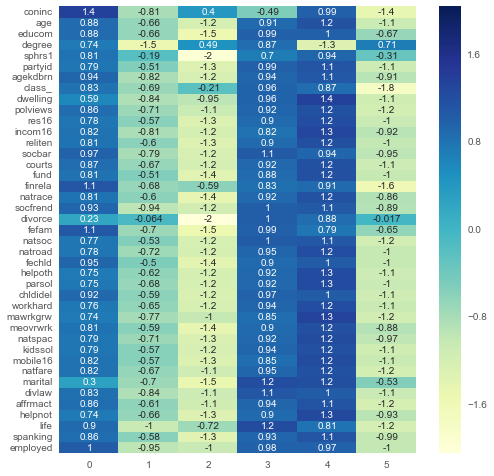

In [106]:
# heat map
plt.figure(figsize=(8,8))
sns.heatmap(summary.T,cmap="YlGnBu",annot=True)

In [107]:
# Check cosine similarity
cos_dict = df_cosine_dist(summary.T)
cos_dict

OrderedDict([((0, 3), 0.08),
             ((0, 4), 0.09),
             ((3, 4), 0.09),
             ((1, 5), 0.13),
             ((2, 5), 0.16),
             ((1, 2), 0.2),
             ((1, 4), 1.83),
             ((0, 2), 1.87),
             ((3, 5), 1.88),
             ((1, 3), 1.92),
             ((2, 4), 1.94),
             ((0, 5), 1.94),
             ((2, 3), 1.94),
             ((0, 1), 1.95),
             ((4, 5), 1.96)])

#### First 6 pairs are from same employed groups, because they have gone through same decision tree path which is consistant with random forest results. 

### However, the ranking of cosine similarity across employed groups, gives us some insight on how similar between blusters and which features result in different employment status.

In [108]:
# anking of cosine similarity across employed groups
list(cos_dict.iteritems())[6:]

[((1, 4), 1.83),
 ((0, 2), 1.87),
 ((3, 5), 1.88),
 ((1, 3), 1.92),
 ((2, 4), 1.94),
 ((0, 5), 1.94),
 ((2, 3), 1.94),
 ((0, 1), 1.95),
 ((4, 5), 1.96)]

According to the paired cosine similarity result. Unemployed cluster 1 and employed cluster 4 are most similar across employed groups. Also, amongest the unployed group, cluster 1 has more "blue" colors which indicates that they are closer to the employed group. 

On the other hand, cluster (4,5),(0,1) differs the most. 

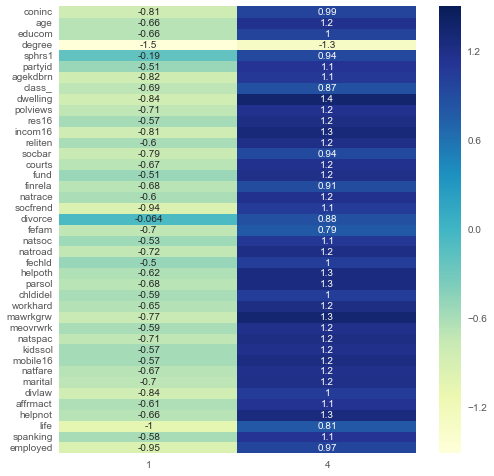

In [109]:

plt.figure(figsize=(8,8))
sns.heatmap(summary.ix[[1,4]].T,cmap="YlGnBu",annot=True)

In order to determine which feature or features make these two clusters differ. Features are taken out one at a time, then check cosine similarity. Rank cosine similarity in ascending order. The features result in smaller consine similarities are the ones make clusters different.

In [110]:
c1 = summary.ix[1]
c4 = summary.ix[4]

In [111]:
lis = []
for i in c1.index:
    ind = [x for x in c1.index if x!=i]
    lis.append(cosine_distance(c1[ind],c4[ind]))

In [112]:
c1.index[np.argsort(lis)[:5]]

Index([u'dwelling', u'incom16', u'mawrkgrw', u'natroad', u'natspac'], dtype='object')

Or rank the differeces of two cluster.

In [113]:
c1.index[(c4-c1).values.argsort()[::-1][:5]]

Index([u'dwelling', u'mawrkgrw', u'incom16', u'socfrend', u'natroad'], dtype='object')

These two algorithms give the similar results. Now we can check these important features

## compare cluster 1 and 4

In [114]:
df = pd.read_pickle('data/df_id.pkl')

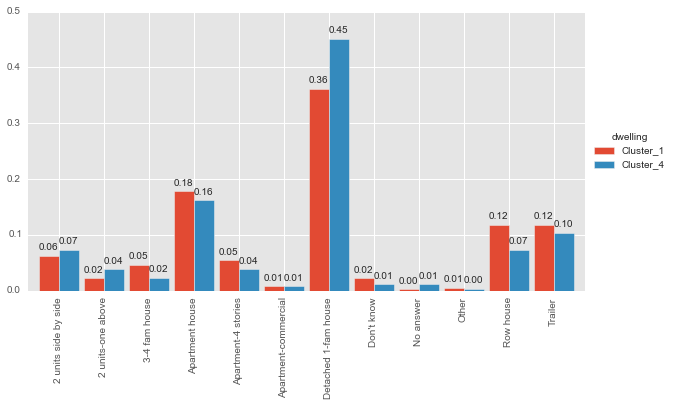

In [129]:
dwl = two_bar(df,1,4,'dwelling')


In [116]:
cluster_ztest_df(dwl,False)

[(u'Detached 1-fam house', 2.26, 0.01), (u'Row house', -1.83, 0.03)]

### More people living in 1-family house than cluster 1. And more people in cluster 1 liviing in row house than cluster 4

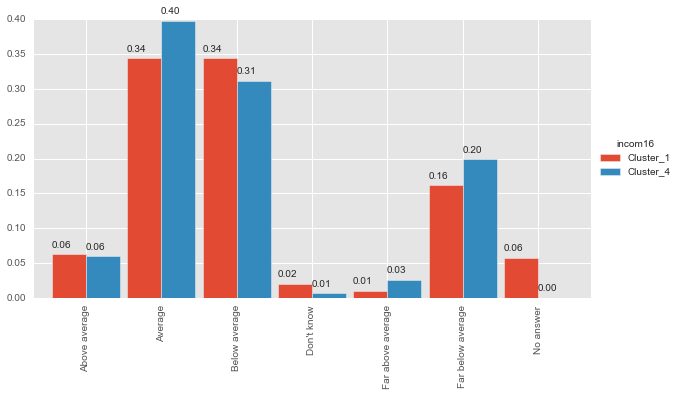

In [117]:
incm = two_bar(df,1,4,'incom16')


In [118]:
cluster_ztest_df(incm,False)

[]

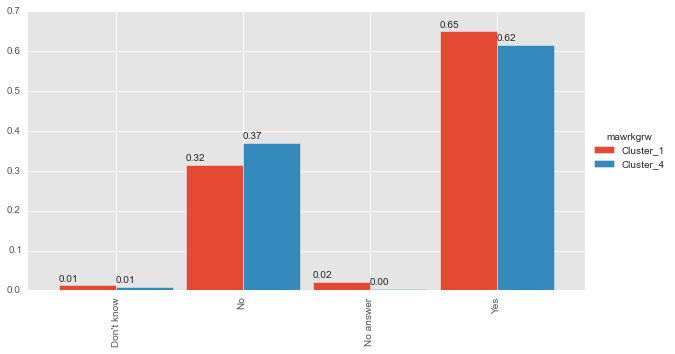

,Don't know,No,No answer,Yes
Cluster_1,4,99,7,204
Cluster_4,2,82,1,136


In [119]:
maw = two_bar(df,1,4,'mawrkgrw')
maw

In [120]:
cluster_ztest_df(maw,False)

[(u'No answer', -1.67, 0.05)]

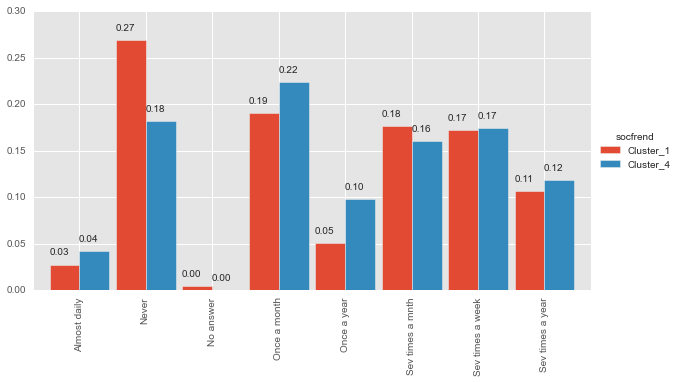

,Almost daily,Never,No answer,Once a month,Once a year,Sev times a mnth,Sev times a week,Sev times a year
Cluster_1,6,58,1,41,11,38,37,23
Cluster_4,6,26,NaN,32,14,23,25,17


In [121]:
socfrnd = two_bar(df,1,4,'socfrend')
socfrnd

In [122]:
cluster_ztest_df(socfrnd,False)

[(u'Never', -1.92, 0.03), (u'Once a year', 1.7, 0.04)]

### More women in cluster 1 answered "never spend evening with friend"

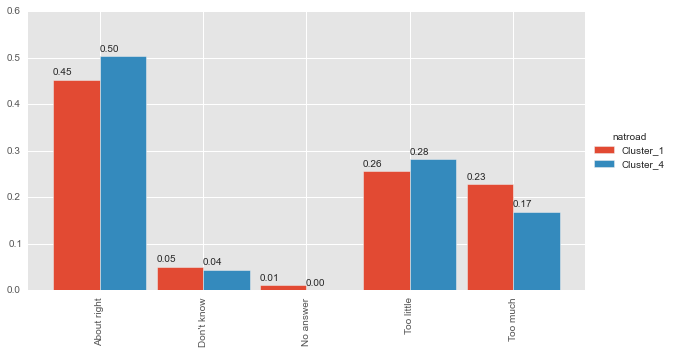

,About right,Don't know,No answer,Too little,Too much
Cluster_1,159,18,4,90,80
Cluster_4,125,11,NaN,70,42


In [123]:
road = two_bar(df,1,4,'natroad')
road

In [124]:
cluster_ztest_df(road, False)

[(u'Too much', -1.75, 0.04)]

### More women in cluster1 thinks government spend too much money on highway and bridge. 

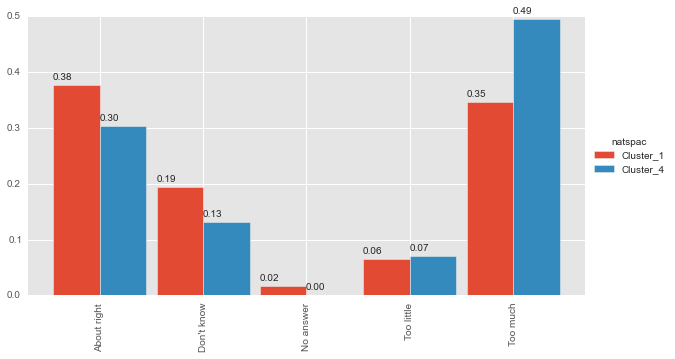

,About right,Don't know,No answer,Too little,Too much
Cluster_1,64,33,3,11,59
Cluster_4,30,13,NaN,7,49


In [125]:
spc = two_bar(df,1,4,'natspac')
spc

In [126]:
cluster_ztest_df(spc, False)

[(u'Too much', 2.39, 0.01)]

### More women in cluster 4, think goverment spend too much on Space exploration program.


## Conclusion:
Cluster1 and cluster 4 are simialr. They have children early, from poor family. But the empoloyed cluster 4 are more socialized and care more about 